# Astrometric observation simulations with MICADO and SCAO

In this eample we demonstate the sub-pixel precision of ScopeSim simulation by creating a grid of moving stars and simulating observations of two epochs.
The second part then applies the same workflow to the motions of stars in a star cluster.
For the sake of computational speed we use the ``MICADO`` package.
We use the wide-field mode (4 mas / pixel) so that the sub-pixel motions of the stars are visible in the flux distribution of the PSF cores.

In [1]:
%matplotlib inline
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as u

import scopesim as sim
import scopesim_templates as sim_tp

As always, the first step is to make sure all instrument packages are present in the working directory.
The assumption is that SCAO observations will use the MICADO internal SCAO system. 
Hence the MORFEO package is not required for this optical models.

    sim.download_packages(["Armazones", "ELT", "MORFEO", "MICADO"])
    
.. note:: In ScopeSim v0.5 both download_packages (new format) and download_package (old format) exist.

If we would like to keep the instrument packages in a separate directory, we can set the following config value:

    sim.rc.__config__["!SIM.file.local_packages_path"] = "path/to/packages"

## Set up a source with 4 stars in a grid pattern

For the first part of this exercise we create a grid of stars seperated by 32 mas.
The ``ScopeSim_templates`` pacakge has a helper function for making griods of stars in the ``basic.stars`` submodule:

['A0V']


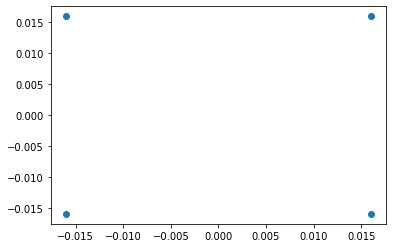

In [2]:
stars = sim_tp.star_grid(n=4, mmin=15, mmax=15, filter_name="Ks", separation=0.032)

plt.scatter(stars.fields[0]["x"], stars.fields[0]["y"])

## Set up the MICADO system for SCAO 4mas Pa-beta observations

The next step is to set up the ``MICADO`` optical system using the ``SCAO`` and wide-field optics (``IMG_4mas``) modes.
As we know in advance that we want to use the Pa-Beta filter, we can set this parameter by passing a dictionary to the ``properties=`` keyword.

Additionally, we are only interested in a small section of the detector around where the 4 stars will be located.
We can therefore set our Detector to only read out the desired window area.
The required "!-bang" string keywords for this are ``!DET.width`` and ``!DET.height`` (given in units of pixels).

As we are interested in the sub-pixel movements of the stars, it is also important to set the ``!SIM.sub_pixel.flag`` to True

Given that we are observing at a non-standard broadband filter, we need to instruct the ``OpticalTrain`` to adjust the PSF strehl ratio.
This is done with the ``!INST.psf`` dictionary.

In [3]:
observation_dict = {
    "!OBS.filter_name_pupil": "Pa-beta",
    "!OBS.filter_name_fw1": "open",
    "!OBS.filter_name_fw2": "open", 
    "!INST.filter_name": "Pa-beta",
    "!OBS.ndit": 20, 
    "!OBS.dit": 3,

    "!OBS.instrument": "MICADO",
    "!OBS.catg": "SCIENCE",
    "!OBS.tech": "IMAGE",
    "!OBS.type": "OBJECT",
    "!OBS.mjdobs": datetime.datetime(2022, 1, 1, 2, 30, 0)
}


cmd = sim.UserCommands(
    use_instrument="MICADO",
    set_modes=["SCAO", "IMG_4mas"],
    properties=observation_dict,
)
cmd["!DET.width"] = 32     # pixel
cmd["!DET.height"] = 32

cmd["!SIM.sub_pixel.flag"] = True

cmd["!INST.psf.strehl"] = 0.1
cmd["!INST.psf.wavelength"] = 1.2

With all these parameters set, we can finally build the optical model and observe the stars.

In [4]:
micado = sim.OpticalTrain(cmd)
micado.observe(stars)
hdus = micado.readout()

As we can see below the 4 stars appear nicely positioned in the grid.
The pixelated 1st Airy ring is also visible.
We chose the wide-field (4mas) mode for this example especially for this reason.

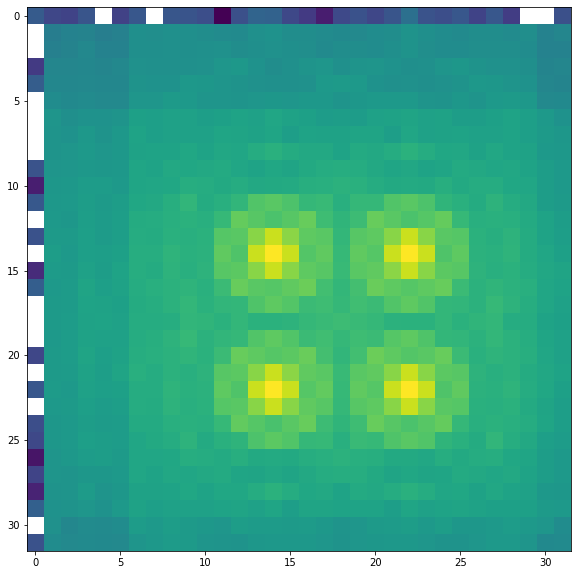

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(hdus[0][1].data, norm=LogNorm())

## Observing a second Epoch

To simulate the movement of the stars due to their proper motions over time, we can shift the stars by a random fraction of a pixel in both directions using the ``.shift`` method of a point-source ``Source`` object.

In [6]:
dx, dy = 0.004 * np.random.random(size=(2, 4))
stars.shift(dx=dx, dy=dy)

As the ``MICADO`` optical model already exists and we do not want to change anything about the system, we can simply observe and readout the updated ``Source`` again.

In [7]:
micado.observe(stars)
hdus2 = micado.readout()

The added random fraction of a pixel motion to each star results in the centre of mass of each star being unaligned with the pixel.

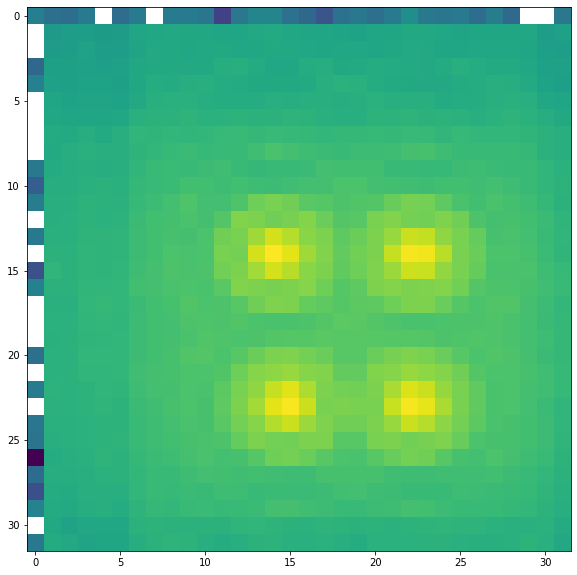

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(hdus2[0][1].data, norm=LogNorm())

## Cluster movement use case

The above examples are nice for illustrating a simple use case. 
For more complex cases, such as the motions of stars within a star cluster, the work flow remains the same.
We can use the ``ScopeSim_Templates`` package function to create a plausible open cluster containing 10 solar masses worth of stars, located at a distance of 8 kpc. The core radius of 0.002 pc is wildly unrealistic, but this dense core serves the purpose of illustrating the sub-pixel nature of ScopeSim simulations.

Here ``t0_cluster`` and ``t1_cluster`` are two realisation of the same cluster at different epochs.

While the ``.shift`` method described above would also be perfectly applicable here, we will create a copy of the original cluster object for the second Epoch. This allows us to visualise the "before and after" of the cluster simulations.

We also show how to access the table containing the spatial information inside the ``Source`` object's ``.fields`` attribute.

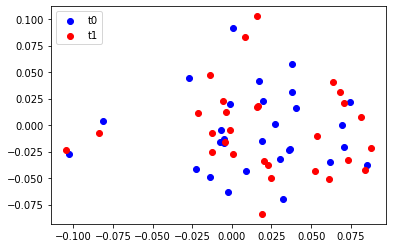

In [9]:
from copy import deepcopy
t0_cluster = sim_tp.cluster(mass=10, core_radius=0.002, distance=8000)
t1_cluster = deepcopy(t0_cluster)

pm_x, pm_y = np.random.normal(0, 0.02, size=(2, len(t0_cluster.fields[0])))

t1_cluster.fields[0]["x"] += pm_x
t1_cluster.fields[0]["y"] += pm_y

plt.scatter(t0_cluster.fields[0]["x"], t0_cluster.fields[0]["y"], c="b", label="t0")
plt.scatter(t1_cluster.fields[0]["x"], t1_cluster.fields[0]["y"], c="r", label="t1")
plt.legend(loc=2)

## Observing the two epochs of the cluster

For an astrometric science case we are more likely to use the MICADO zoom optics (1.5mas / pixel).
Therefore we recreate the optical mode with the updated ``set_modes`` keyword (``IMG_1.5mas``).

We also expand the size of the detector window to 256x256 pixels in order to fit our unrealisticly dense open cluster.

In [10]:
observation_dict = {
    "!OBS.filter_name_pupil": "open",
    "!OBS.filter_name_fw1": "J",
    "!OBS.filter_name_fw2": "open", 
    "!INST.filter_name": "Pa-beta",
    "!OBS.ndit": 1, 
    "!OBS.dit": 3600,

    "!OBS.instrument": "MICADO",
    "!OBS.catg": "SCIENCE",
    "!OBS.tech": "IMAGE",
    "!OBS.type": "OBJECT",
    "!OBS.mjdobs": datetime.datetime(2022, 1, 1, 2, 30, 0)
}

cmd = sim.UserCommands(
    use_instrument="MICADO",
    set_modes=["SCAO", "IMG_1.5mas"],
    properties=observation_dict,
)
cmd["!DET.width"] = 256     # pixel
cmd["!DET.height"] = 256

cmd["!SIM.sub_pixel.flag"] = True

micado = sim.OpticalTrain(cmd)

Observing and reading out the MICADO detector for each ``Source`` object is quite obvious by now

In [11]:
micado.observe(t0_cluster)
t0_hdus = micado.readout()

micado.observe(t1_cluster)
t1_hdus = micado.readout()

In contrast to the grid of stars being observed with the wide-field mode, the zoom-mode enables us to see much more of the PSF structure. 
The shift in star positions is also quite obvious.

Each ``fits.HDUList`` could also ahve been saved to disk as a regular FITS file by passing a ``filename=`` keyword to the ``readout``method call.
Alternatively we could use the standard ``astropy.fits`` functionality (i.e. the ``writeto()`` method) to save the ``HDUList``s to disk.

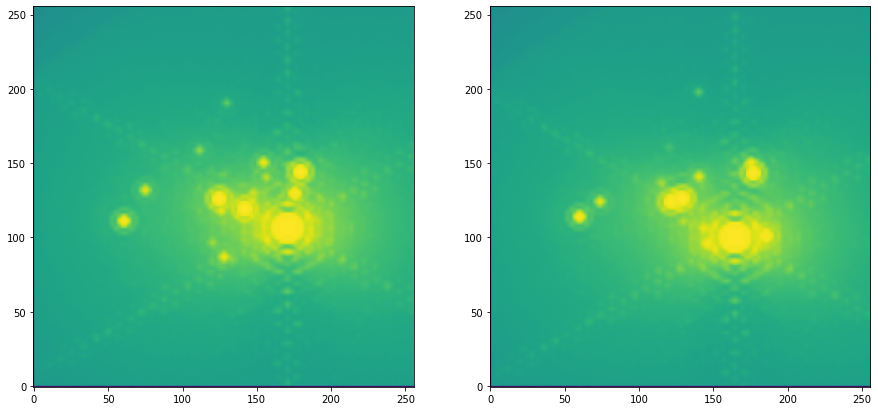

In [12]:
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(t0_hdus[0][1].data, norm=LogNorm(), origin="lower")
plt.subplot(122)
plt.imshow(t1_hdus[0][1].data, norm=LogNorm(), origin="lower")